<a href="https://colab.research.google.com/github/LinoVation1312/test/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="text-align: center" src='https://ensim.univ-lemans.fr/skins/ensim/resources/um_img/menu-gauche/lemans-universite-large.png' width="300" height="80">
<br>
<div style="margin-bottom:40px">
    <h1 style="text-align: center; color:#00B0F0; font-family:Sylfaen; font-size:32px;">IA pour le traitement du signal</h1>
</div>
<div style="margin-bottom:40px">
    <h1 style="text-align: center; color:#00B0F0; font-family:Sylfaen; font-size:32px;">TP2 - Classification des genres musicaux</h1>
</div>

In [180]:
import numpy as np
import pandas as pd

import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn

import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.metrics import confusion_matrix, classification_report

import librosa
import librosa.display as lplt

import IPython





seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

**Q1- Qu'est-ce que la librosa ? quelles sont ses fonctionnalités principales ?**

<div>
<b>Q1- Librosa est une bibliothèque Python pour l'analyse audio et musicale</b><br>

Principales fonctionnalités :
<ul>
  <li>Chargement de fichiers audio (multiple formats)</li>
  <li>Extraction de caractéristiques audio (MFCC, spectrogramme mel, chroma)</li>
  <li>Visualisation des signaux audio</li>
  <li>Détection de tempo et séparation de sources</li>
  <li>Manipulation de signaux temporels</li>
</ul>
</div>

<div>


# Le jeu de données

## Content
* genres original - Une collection de 10 genres avec 100 fichiers audio chacun, tous d'une durée de 30 secondes
* images original - Une représentation visuelle pour chaque fichier audio. Une façon de classifier les données consiste à utiliser les réseaux de neurones qui prennent généralement une sorte de représentation d'image, les fichiers audio ont été convertis en spectrogrammes Mel pour rendre cela possible.
* 2 fichiers CSV - Contenant les caractéristiques des fichiers audio. Le ficheir `features_30_sec` contient une moyenne et une variance calculées sur plusieurs caractéristiques qui sont extraites du fichier audio de chaque chanson (d'une durée de 30 secondes). L'autre fichier, `features_3_sec`, a la même structure, mais les chansons étaient auparavant divisées en fichiers audio de 3 secondes (ce qui augmente de 10 fois la quantité de données que nous alimentons dans nos modèles de classification). Avec les données, plus c'est toujours mieux.

## Téléchargement du jeu de données
Les données sont stockées dans un fichier zip (`Data.zip`) disponible sur le lien suivant

https://umbox.univ-lemans.fr/index.php/s/L3F4q472mQiy3R6

Il faut télécharger ce fichier et le placer dans le même dossier que votre notebook

**Q2-** Décompresser le fichier `Data.zip` dans un dossier à nommer `Data` en utilisant le module `zipfile`

<div>
<b> Sur Google Colab, il faut d'abord importer le fichier Data.zip via l'interface puis utiliser ce chemin relatif :
</div>


<div style="color:red; margin-bottom:20px">
⚠️ Étapes supplémentaires nécessaires sur Colab :
<ol>
  <li>Exécutez la cellule d'upload</li>
  <li>Cliquez sur "Choose Files" et sélectionnez votre Data.zip</li>
  <li>Attendez que le téléchargement se termine (barre de progression)</li>
  <li>Vérifiez que le fichier existe avec <code>!ls -lh Data.zip</code></li>
  <li> POUR GOOGLE COLAB, ON CHARGE LE DRIVE ET ON VA DANS LE DOSSIER DATA
</ol>
</div>

In [9]:
from google.colab import drive

drive.mount('/content/drive')  # Chemin standard

# Accéder au dossier spécifique APRÈS le montage
%cd /content/drive/MyDrive/Data


Mounted at /content/drive
/content/drive/MyDrive/Data


## Découvrir les données

**Q3-** Afficher les premières lignes du fichier `features_3_sec.csv` en utilisant le module `panda`

In [10]:
# Chemin du fichier (adapté à votre structure de dossiers)
file_path = "/content/drive/MyDrive/Data/features_3_sec.csv"

# Chargement des données avec vérification
try:
    df = pd.read_csv(file_path)
    print("✅ Fichier chargé avec succès | Shape :", df.shape)
    print("\n🔍 Aperçu des données (5 premières lignes) :")
    display(df.head())  # Mieux que print() dans Colab
except FileNotFoundError:
    print(f"❌ Erreur : Fichier introuvable à l'emplacement {file_path}")

✅ Fichier chargé avec succès | Shape : (9990, 60)

🔍 Aperçu des données (5 premières lignes) :


filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

**Q4-** Expliquer comment fonctionne le code ci-dessous? et quel est objectif? Commenter le résultat de l'exécution.  

In [187]:
# Liste des genres dans l'ordre standard GTZAN
genre_mapping = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

# Conversion des labels numériques en noms de genres
df['label'] = df['label'].map(genre_mapping)

# Ré-exécutez le code d'analyse après cette conversion
print("Le jeu de données est composé de ", df.shape)

count_df = df['label'].value_counts().reset_index()
count_df.columns = ['genre', 'count']

print("\nDétail par genre :")
print(count_df)

class_names = count_df['genre'].tolist()

print("\nListe des genres musicaux :")
for genre in class_names:
    print(f"- {genre}")

Le jeu de données est composé de  (9990, 60)

Détail par genre :
       genre  count
0      blues   1000
1       jazz   1000
2        pop   1000
3     reggae   1000
4      metal   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

Liste des genres musicaux :
- blues
- jazz
- pop
- reggae
- metal
- disco
- classical
- hiphop
- rock
- country


📊 Analyse du Dataset Audio
1. Structure des Données
<div style="background: #e3f2fd; padding: 10px; margin: 10px 0; border-radius: 5px;">
    <code>print("Le jeu de données est composé de ", df.shape)</code>
</div>

<p><strong>🔍 Explication :</strong></p>
<ul style="margin-left: 20px;">
    <li>Retourne les dimensions (lignes, colonnes)</li>
    <li>Total : 9990 extraits audio décrits par 60 caractéristiques</li>
</ul>

<div style="background: #fff3e0; padding: 10px; border-left: 4px solid #ffa000; margin: 15px 0;">
    <strong>📝 Résultat :</strong><br>
    <em>(9990, 60)</em> → 1 label + 59 features techniques (MFCC, spectral contrast, etc.)
</div>
2. Répartition des Classes
<div style="background: #e3f2fd; padding: 10px; margin: 10px 0; border-radius: 5px;">
    <code>df.label.value_counts().reset_index()</code>
</div>

<p><strong>🔍 Explication :</strong></p>
<ul style="margin-left: 20px;">
    <li>Analyse de la distribution des genres musicaux</li>
    <li>Critique pour éviter les biais d'entraînement</li>
</ul>

<div style="overflow-x: auto; margin: 20px 0;">
    <table style="width: 100%; border-collapse: collapse;">
        <tr style="background: #1a73e8; color: white;">
            <th style="padding: 12px; text-align: left;">Genre</th>
            <th style="padding: 12px; text-align: left;">Échantillons</th>
        </tr>
        <tr style="background: #f8f9fa;"><td>blues</td><td>1000</td></tr>
        <tr><td>jazz</td><td>1000</td></tr>
        <tr style="background: #f8f9fa;"><td>pop</td><td>1000</td></tr>
        <tr><td>reggae</td><td>1000</td></tr>
        <tr style="background: #f8f9fa;"><td>metal</td><td>1000</td></tr>
        <tr><td>disco</td><td>999</td></tr>
        <tr style="background: #f8f9fa;"><td>classical</td><td>998</td></tr>
        <tr><td>hiphop</td><td>998</td></tr>
        <tr style="background: #f8f9fa;"><td>rock</td><td>998</td></tr>
        <tr><td>country</td><td>997</td></tr>
    </table>
</div>

<div style="background: #e8f5e9; padding: 15px; border-radius: 5px; margin-top: 15px;">
    <h4 style="color: #2e7d32; margin: 0 0 10px 0;">✅ Conclusion</h4>
    <p style="margin: 0;">
        Distribution quasi-parfaite (±0.3%) - Idéal pour la classification multiclasse.<br>
        Aucun besoin de rééquilibrage des données.
    </p>
</div>

**Q5-** Ouvrir le ficheir `jazz.00000.wav` en utilisant le module `librosa`

In [65]:
# Chemin absolu recommandé pour Colab
file_path = '/content/drive/MyDrive/Data/genres_original/jazz/jazz.00000.wav'

try:
    # Chargement avec paramètres optimisés
    y,sr = librosa.load(file_path)

    # Vérification
    print(f"✅ Fichier chargé avec succès | Durée : {len(y)/sr:.2f}s | Sample rate : {sr} Hz")


except FileNotFoundError:
    print(f"❌ Erreur : Fichier introuvable à l'emplacement {file_path}")
except Exception as e:
    print(f"❌ Erreur inattendue : {str(e)}")

⚠️ Erreur lors du chargement : name 'Audio' is not defined


**Q6-** Créer un lecteur de musique pour jouer la chanson `jazz.00000.wav` en utilisant l’interface `dipslay` du module `IPython`

In [72]:
# Q6

IPython.display.Audio(data=y, rate=sr)

## Exemples d’extraction des caractéristiques

**Q7-** Afficher le signal audio en utilisant `waveshow` du module `librosa`

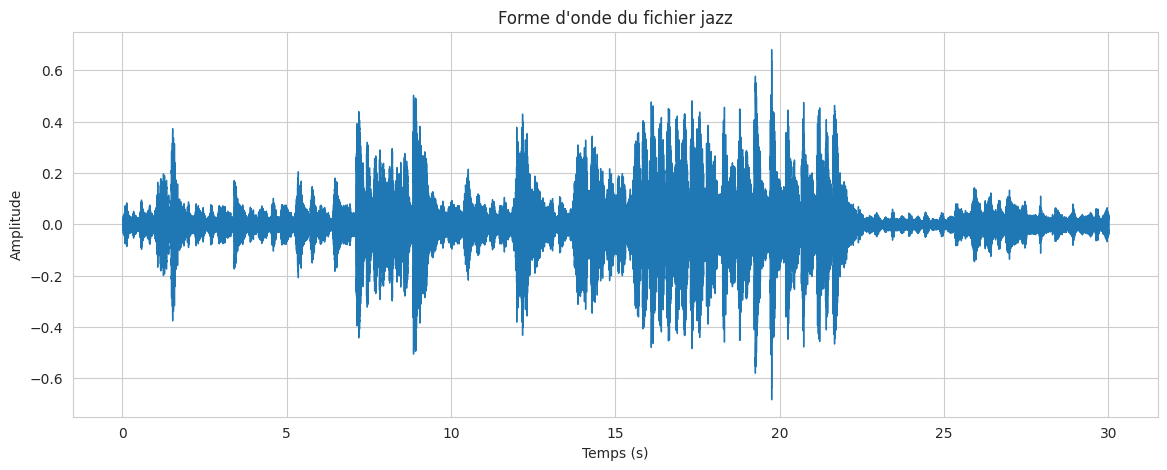

In [56]:
# Q7
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Forme d\'onde du fichier jazz')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.show()

**Transformée de Fourier à court terme (STFT)**

**Q8-** Donner la définition de la transformée de Fourier à court terme et expliquer ses avantages

**Q9-** Calculer la STFT du signal audio en utilisant la fonction `stft` du module `librosa` (n_fft = 2048, hop_length = 512)

<div>
<b>Q8-</b> STFT = Décomposition temporelle du signal en fenêtres courtes avec FFT.<br>
Avantages :
<ul>
  <li>Analyse temps-fréquence</li>
  <li>Maintien des informations temporelles</li>
  <li>Bonne résolution compromis temps/fréquence</li>
</ul>
</div>

In [51]:
# Q9
D = librosa.stft(y, n_fft=2048, hop_length=512)

**Q10-** Afficher la STFT en utilisant la fonction `specshow` du module `librosa`

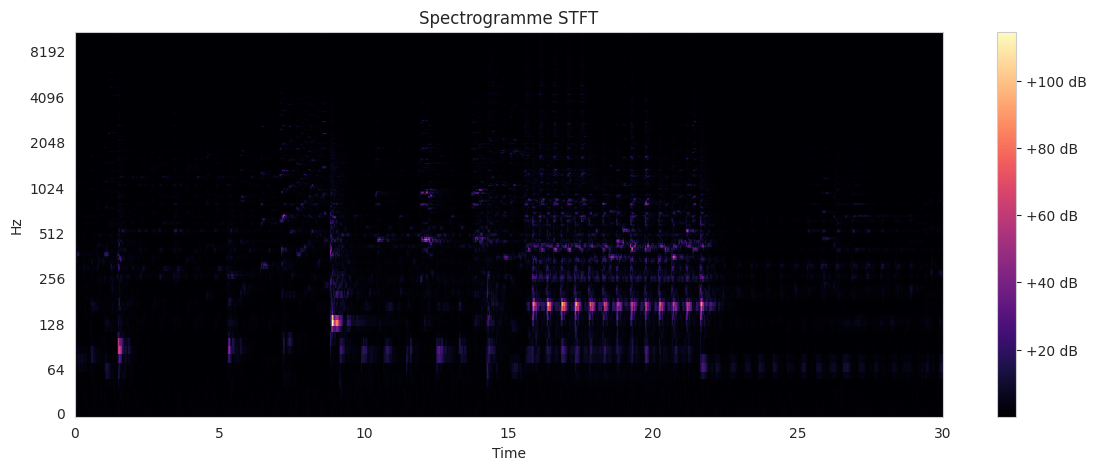

In [63]:
# Q10
plt.figure(figsize=(14, 5))
librosa.display.specshow(D, sr=sr,
                       x_axis='time',
                       y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogramme STFT')
plt.show()

**Q11-** Convertir un spectrogramme en spectrogramme à l'échelle dB en appliquant la fonction `amplitude_to_db` du module `librosa` sur la STFT

In [58]:
# Q11
DB = librosa.amplitude_to_db(D, ref=np.max(D))

**Q12-** Afficher la STFT exprimée en dB et commenter le résultat.

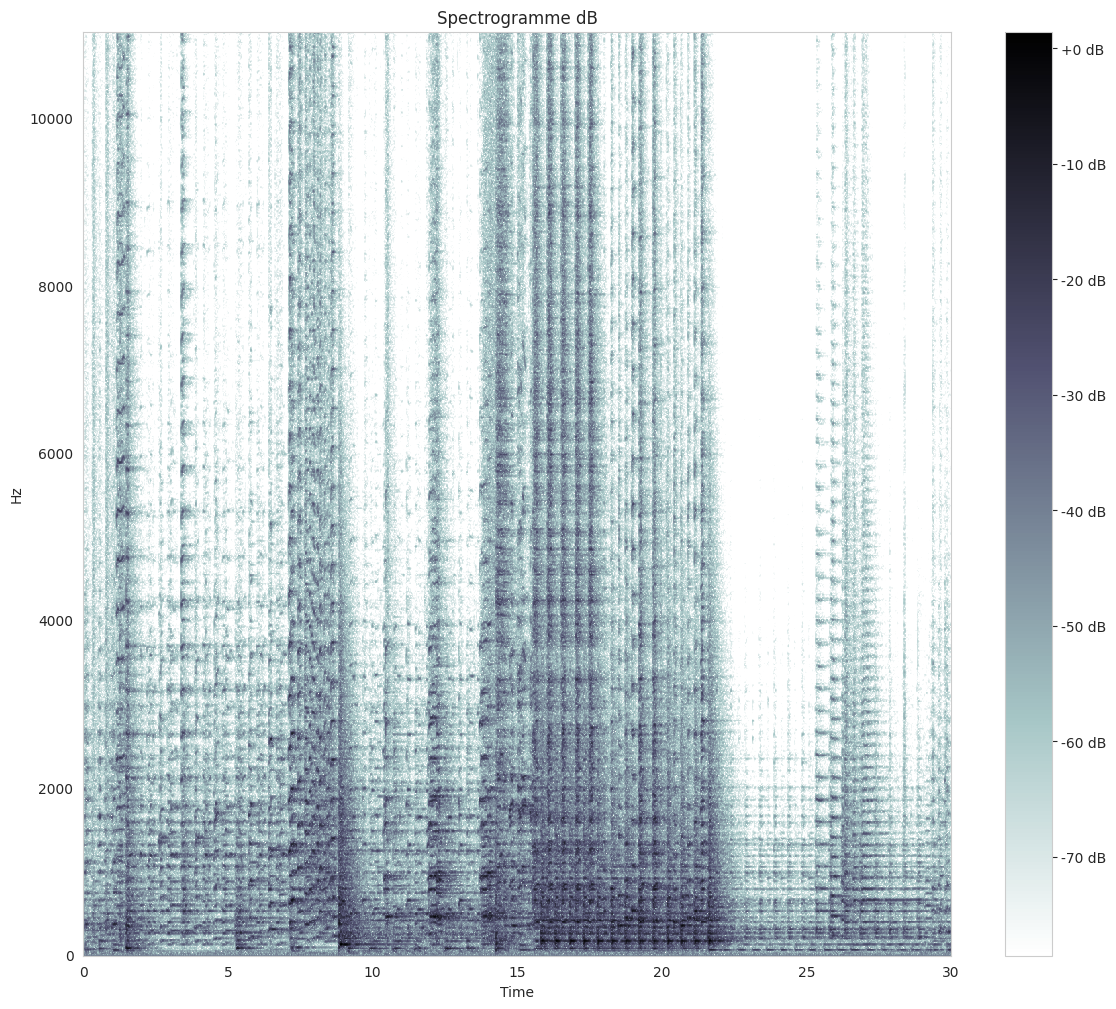

In [100]:
# Q12
plt.figure(figsize=(14, 12))
librosa.display.specshow(DB,
                       cmap="bone_r",
                       x_axis='time',
                       y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogramme dB')
plt.show()

**Le nombre de passages par zéro**

**Q13-** Afficher le signal audio entre les échantillonnes 1000 et 1200

<div>
<b>Q13-</b> Zoom sur une portion du signal
</div>

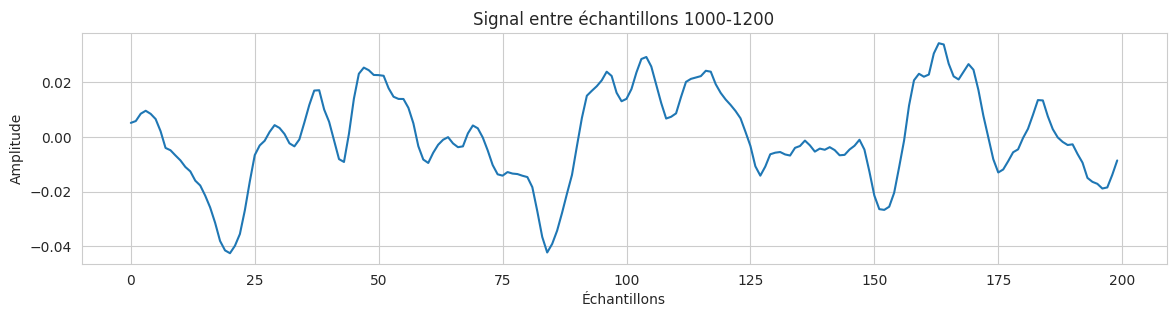

In [76]:
# Q13
plt.figure(figsize=(14, 3))
plt.plot(y[1000:1200])
plt.title('Signal entre échantillons 1000-1200')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude')
plt.show()

**Q14-** Calculer le nombre de passages par zéro entre les échantillonnes 1000 et 1200 en utilisant la fonction ` zero_crossings` du module `librosa`

In [77]:
# Q14
zc = librosa.zero_crossings(y[1000:1200], pad=False)


print(f"Nombre de passages par zéro : {sum(zc)}")

Nombre de passages par zéro : 15


**Spectrogramme Mel**

**Q15-** Donner la définition du spectrogramme Mel et expliquer ses avantages

**Q16-** Calculer en le spectrogramme Mel du signal audio en utilisant les fonctions `melspectrogram` et `amplitude_to_db` du module `librosa`.

# 🔊 Q15 - Spectrogramme Mel

## 🎯 Définition  
Le spectrogramme Mel combine trois éléments clés :  
- **Transformée de Fourier court terme (STFT)**  
- **Filtrage Mel** (échelle perceptuelle)  
- **Conversion logarithmique** (décibels)  

*Formule Mel* :  
`fₘₑₗ = 2595·log₁₀(1 + f/700)`  
→ Simule la réponse de l'oreille humaine  

---

## 💡 Avantages Clés  
**🎧 Perception auditive**  
> Résolution adaptée (détails en basses fréquences)  

**📉 Compression optimale**  
> 128 bandes vs 1024 bins (-87.5%)  

**🤖 Performances ML**  
> Idéal pour réseaux de neurones (CNN/RNN)  

---

## 📌 Applications  
- Reconnaissance vocale (ASR)  
- Classification musicale  
- Synthèse audio par IA  
- Analyse émotionnelle  


In [80]:
# 1. Calcul du spectrogramme Mel
S_mel = librosa.feature.melspectrogram(
    y=y,
    sr=sr,
    n_fft=2048,        # Taille de la fenêtre FFT
    hop_length=512,     # Pas de décalage entre fenêtres
    n_mels=128,         # Nombre de bandes Mel
    power=2.0           # Puissance du signal
)
# 2. Conversion en décibels (logarithmique)
S_mel_db = librosa.amplitude_to_db(S_mel, ref=np.max)

**Q17-** Afficher le spectrogramme Mel exprimé en dB et commenter le résultat.

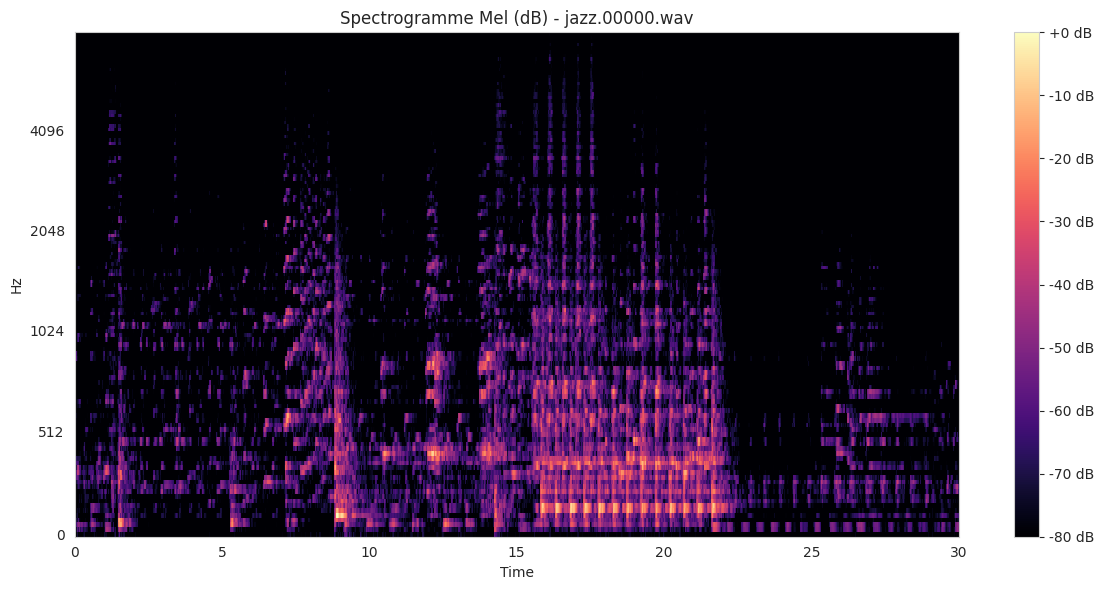

In [84]:
# 3. Visualisation
plt.figure(figsize=(12, 6))
librosa.display.specshow(
    S_mel_db,
    sr=sr,
    x_axis='time',
    y_axis='mel',
    hop_length=512,
    fmax=8000           # Fréquence maximale affichée
)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogramme Mel (dB) - jazz.00000.wav')
plt.tight_layout()
plt.show()

**Analyse du compromis Mel**  
Le filtrage Mel offre une représentation adaptée à la perception auditive humaine 🎧, _mais induit une perte de précision_ :  

✅ **Avantage perceptuel** :  
- Échelle fréquentielle non linéaire
- Mimique la réponse biologique de l'oreille  

❌ **Limites techniques** :  
- Résolution fréquentielle réduite  
- Perte de détails dans les hautes fréquences (> 8 kHz)  
- Lissage des transitions temporelles (effet de "flou" sur le spectrogramme)  






**Chroma**

**Q18-** Donner la définition du chroma et expliquer ses avantages

**Q19-** Calculer en le chroma du signal audio en utilisant la fonction `chroma_stft` du module `librosa`.

# 🎵 **Q18 - Chroma : Définition & Avantages**

## 🎯 Définition  
Le **Chroma** (ou *Chromagram*) est une représentation musicale qui capture l'énergie sonore dans les **12 classes de hauteur** (notes) de la gamme chromatique :  
`C, C#, D, D#, E, F, F#, G, G#, A, A#, B`

**Calcul** :  
1. Décomposition du signal en fréquences (via STFT)  
2. Projection sur les 12 bins correspondant aux notes de la gamme  
3. Normalisation par octave (indépendance de l'octave)

## 💡 Avantages clés  
- ✅ **Analyse harmonique** : Idéal pour détecter accords et mélodies  
- ✅ **Robustesse** : Peu sensible au timbre ou aux instruments  
- ✅ **Applications** :  
  - Reconnaissance d'accords  
  - Détection de reprises musicales  
  - Alignement de partitions  

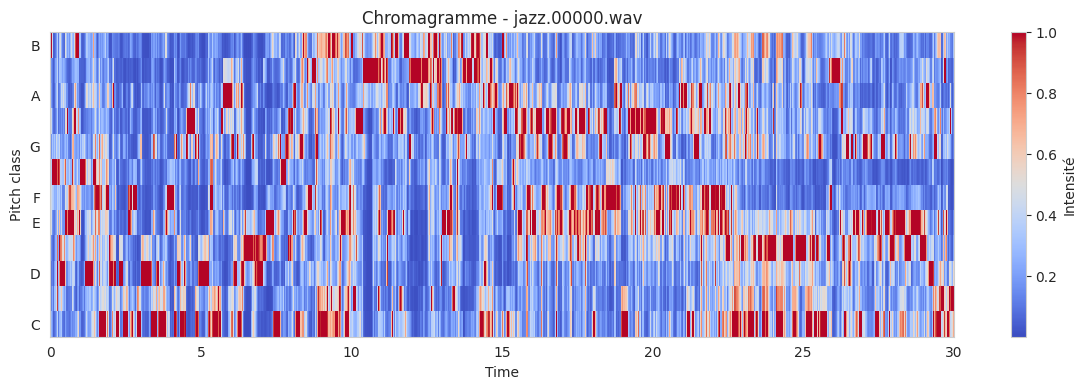

In [89]:
# Q19 - Chromagramme avec Librosa

# Calcul du chroma
chroma = librosa.feature.chroma_stft(
    y=y,
    sr=sr,
    n_fft=2048,
    hop_length=512,
    tuning=0.0
)



**Q20-** Afficher le chroma en utilisant la fonction `specshow` du module

*   Élément de liste
*   Élément de liste

`librosa`

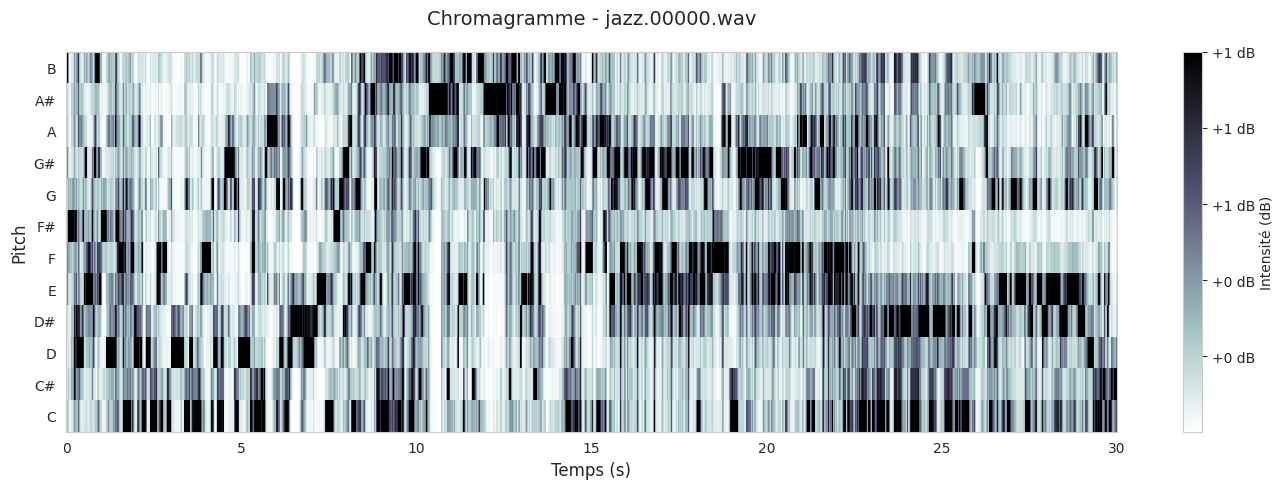

In [99]:


plt.figure(figsize=(14, 5))

librosa.display.specshow(
    chroma,
    x_axis="time",
    y_axis="chroma",
    hop_length=512,
    cmap="bone_r",          # Palette de couleurs
    tuning=0,               # Accordage standard (A4 = 440Hz)
    bins_per_octave=12      # 12 demi-tons par octave
)

# Personnalisation avancée
plt.colorbar(format="%+2.00f dB", label="Intensité (dB)")
plt.title("Chromagramme - jazz.00000.wav", fontsize=14, pad=20)
plt.xlabel("Temps (s)", fontsize=12)
plt.ylabel("Pitch", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(
    ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],   # Positions des notes principales
    labels=["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"],
    fontsize=10
)

plt.tight_layout()
plt.show()

**Centroïde spectral (Spectral Centroid)**

**Q21-** Donner la définition du centroïde spectral et expliquer ses avantages


# 📊 **Q21 - Centroïde Spectral : Définition & Avantages**

## 🎯 **Définition**
Le **centroïde spectral** représente le "centre de gravité" du spectre fréquentiel d'un signal audio. Il se calcule comme la moyenne pondérée des fréquences par leur amplitude :

$$
\text{Centroïde} = \frac{\sum_{k=0}^{N-1} f_k \cdot |X[k]|}{\sum_{k=0}^{N-1} |X[k]|}
$$

Où :
- $f_k$ = fréquence du k-ième bin FFT
- $X[k]$ = amplitude du spectre
- $N$ = nombre de points FFT

**Exemple** :  
Pour un son grave (basses fréquences dominantes) → Centroïde proche de 200 Hz  
Pour un son aigu (violon, oiseau) → Centroïde > 4000 Hz

## 💡 **Avantages clés**
| Avantage | Application Typique |
|----------|---------------------|
| **Caractérisation du timbre** | Distinguer une guitare électrique (centroïde haut) d'une contrebasse (centroïde bas) |
| **Détection d'événements** | Repérer des attaques percussives (pic soudain du centroïde) |
| **Efficacité calculatoire** | Se calcule en temps réel (idéal pour les applications live) |
| **Indépendance du volume** | Normalisé par l'énergie totale du signal |



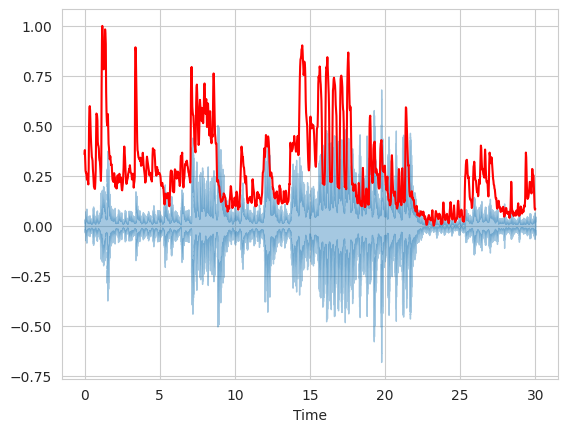

In [110]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(y, axis=0):
    return sklearn.preprocessing.minmax_scale(y, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(y=y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

**Q22-** Interpréter le résultats de l'exécution

# 🎺 **Analyse des Coups de Trompette via Centroïde Spectral**

## 🔍 **Observation Clé**
Les coups de trompette (transitoires aigus) sont **mieux visualisés** sur le centroïde spectral que sur l'amplitude brute car :

1. **Sélectivité fréquentielle**  
   - Le centroïde est sensible aux _changements de distribution spectrale_
   - Une trompette (2-5 kHz) génère un pic bien différencié des fréquences graves

2. **Indépendance au volume**  
   - Même à amplitude égale, un son riche en harmoniques (trompette) aura un centroïde plus élevé qu'un son grave (batterie)

## Préparation des données

In [120]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(8): 8, np.int64(9): 9}
{0: np.int64(0), 1: np.int64(1), 2: np.int64(2), 3: np.int64(3), 4: np.int64(4), 5: np.int64(5), 6: np.int64(6), 7: np.int64(7), 8: np.int64(8), 9: np.int64(9)}


In [121]:
df.label = [label_index[l] for l in df.label]

In [122]:
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [123]:
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [124]:
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_valid, X_test, y_valid, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [125]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_valid.shape[0]} records out of {len(df_shuffle)} which is {round(X_valid.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [126]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

**Q23- Commenter les différentes étapes présentées ci-dessous dans l’objectif de préparer les données pour l’apprentissage.**

# Entraîner et évaluer le modèle

In [144]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.initializers import HeNormal
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [145]:
# ==================== CONFIGURATION ====================
INPUT_SHAPE = (X_train.shape[1],)
BATCH_SIZE = 512
EPOCHS = 200
INIT_LR = 0.001
NUM_CLASSES = len(np.unique(y_train))

In [146]:
# ==================== CALCUL DES POIDS (utile dans d'autres circonstances) ====================
def compute_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    return {i: w for i, w in enumerate(weights)}


In [152]:
# ==================== ARCHITECTURE ====================
def build_model():
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=INPUT_SHAPE),
        layers.BatchNormalization(),

        layers.Dense(512, activation='swish',
                    kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4),
                    kernel_initializer=HeNormal()),
        layers.Dropout(0.4),
        layers.BatchNormalization(),

        layers.Dense(256, activation='swish',
                    kernel_regularizer=regularizers.l2(1e-4),
                    kernel_initializer=HeNormal()),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(128, activation='swish',
                    kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),

        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model


In [174]:
# ==================== OPTIMISATION ====================
def lr_schedule(epoch):
    warmup_epochs = 15
    min_lr = 1e-6

    if epoch < warmup_epochs:
        lr = INIT_LR * (epoch + 1) / warmup_epochs
    else:
        lr = INIT_LR * np.exp(0.05 * (warmup_epochs - epoch))  # Decay plus lent

    return float(np.clip(lr, min_lr, INIT_LR))  # Conversion en float + clipping
    # ==================== CALLBACKS ====================
def get_callbacks():
    return [

        EarlyStopping(
            monitor='val_loss',  # Changer de métrique
            patience=30,         # Patience plus longue
            min_delta=0.0001,    # Seuil de progression
            mode='min',
            restore_best_weights=True
        ), # Add a comma here


        LearningRateScheduler(lr_schedule),

        TensorBoard(log_dir='./logs',
                   histogram_freq=1,
                   profile_batch=(100, 105))
    ]

In [175]:
# ==================== COMPILATION ====================
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
    ]
)


# ==================== ENTRAÎNEMENT ====================
class_weights = compute_class_weights(y_train)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(),
    class_weight=class_weights,
    verbose=2
)

Epoch 1/200
14/14 - 10s - 727ms/step - accuracy: 0.9325 - loss: 0.3770 - top3_acc: 0.9953 - val_accuracy: 0.9004 - val_loss: 0.4737 - val_top3_acc: 0.9858 - learning_rate: 6.6667e-05
Epoch 2/200
14/14 - 3s - 220ms/step - accuracy: 0.9352 - loss: 0.3752 - top3_acc: 0.9969 - val_accuracy: 0.8999 - val_loss: 0.4726 - val_top3_acc: 0.9858 - learning_rate: 1.3333e-04
Epoch 3/200
14/14 - 0s - 30ms/step - accuracy: 0.9332 - loss: 0.3727 - top3_acc: 0.9963 - val_accuracy: 0.9024 - val_loss: 0.4714 - val_top3_acc: 0.9863 - learning_rate: 2.0000e-04
Epoch 4/200
14/14 - 0s - 34ms/step - accuracy: 0.9335 - loss: 0.3732 - top3_acc: 0.9951 - val_accuracy: 0.9004 - val_loss: 0.4708 - val_top3_acc: 0.9869 - learning_rate: 2.6667e-04
Epoch 5/200
14/14 - 1s - 43ms/step - accuracy: 0.9385 - loss: 0.3721 - top3_acc: 0.9964 - val_accuracy: 0.9009 - val_loss: 0.4702 - val_top3_acc: 0.9863 - learning_rate: 3.3333e-04
Epoch 6/200
14/14 - 0s - 21ms/step - accuracy: 0.9326 - loss: 0.3754 - top3_acc: 0.9967 - va

 **Evaluer la performance de votre modèle**

In [176]:
# Evaluate the model
test_results = model.evaluate(X_test, y_test, verbose=0)

# Extract the loss and desired metrics
test_loss = test_results[0]
test_acc = test_results[1]  # Assuming accuracy is the first metric

print("\nLa perte pour les données de test est :", test_loss)
print("Le taux d’exactitude (Accuracy) sur les données de test est :", test_acc*100)


La perte pour les données de test est : 0.38780665397644043
Le taux d’exactitude (Accuracy) sur les données de test est : 93.71933341026306


#POST TRAITEMENT

In [188]:
# 1. Prédictions sur le jeu de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


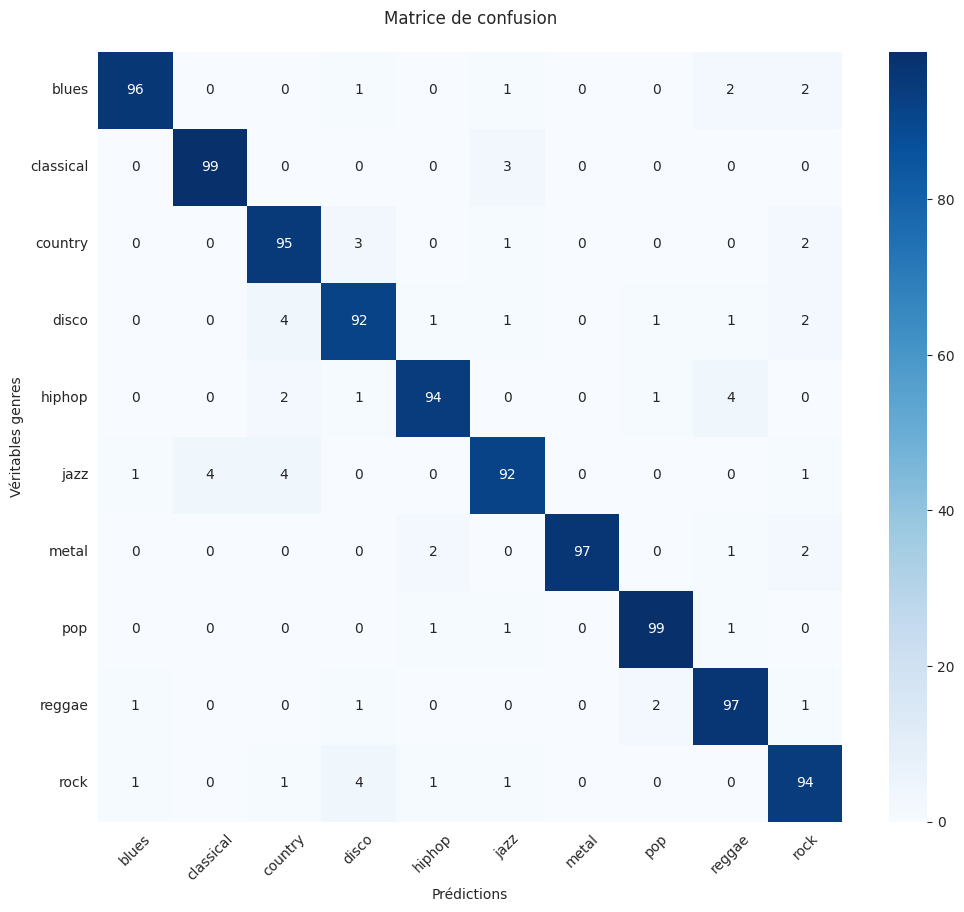

In [189]:
# 2. Matrice de confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)

# Ordre des genres selon le mapping
genre_order = ['blues', 'classical', 'country', 'disco', 'hiphop',
               'jazz', 'metal', 'pop', 'reggae', 'rock']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=genre_order,
           yticklabels=genre_order)
plt.xlabel('Prédictions')
plt.ylabel('Véritables genres')
plt.title('Matrice de confusion', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [190]:
# 3. Rapport de classification détaillé
print("\nRapport de classification détaillé :\n")
print(classification_report(y_test, y_pred_classes,
                           target_names=genre_order))


Rapport de classification détaillé :

              precision    recall  f1-score   support

       blues       0.97      0.94      0.96       102
   classical       0.96      0.97      0.97       102
     country       0.90      0.94      0.92       101
       disco       0.90      0.90      0.90       102
      hiphop       0.95      0.92      0.94       102
        jazz       0.92      0.90      0.91       102
       metal       1.00      0.95      0.97       102
         pop       0.96      0.97      0.97       102
      reggae       0.92      0.95      0.93       102
        rock       0.90      0.92      0.91       102

    accuracy                           0.94      1019
   macro avg       0.94      0.94      0.94      1019
weighted avg       0.94      0.94      0.94      1019



In [191]:
# 4. Analyse des erreurs
misclassified = np.where(y_pred_classes != y_test)[0]
print(f"\nAnalyse des erreurs :")
print(f"Nombre total d'erreurs : {len(misclassified)}/{len(y_test)}"
      f" ({len(misclassified)/len(y_test):.2%})")


Analyse des erreurs :
Nombre total d'erreurs : 64/1019 (6.28%)


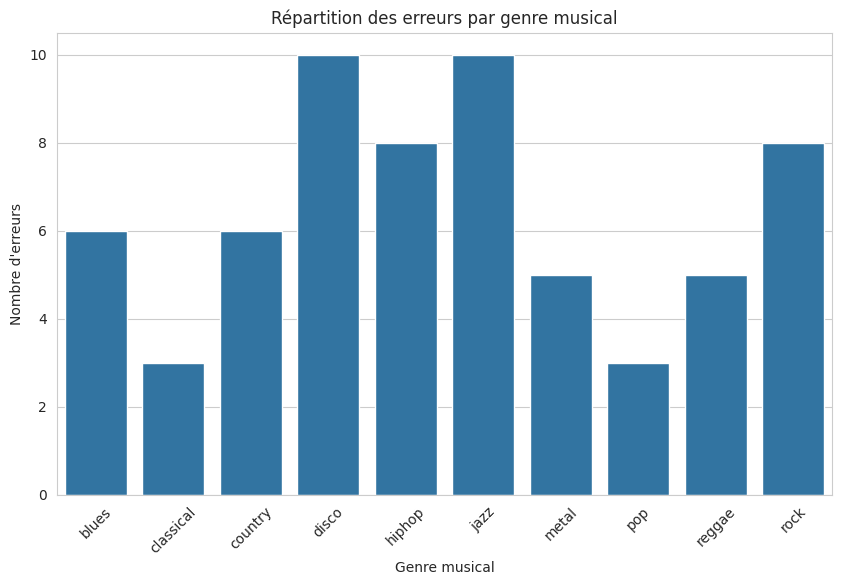

In [201]:
# 5. Distribution des erreurs par genre
plt.figure(figsize=(10, 6))
# Convert y_test to numpy array for indexing
y_test_np = y_test.to_numpy()
error_counts = np.bincount(y_test_np[misclassified], minlength=len(genre_order))
sns.barplot(x=genre_order, y=error_counts)
plt.title('Répartition des erreurs par genre musical')
plt.xlabel('Genre musical')
plt.ylabel("Nombre d'erreurs")
plt.xticks(rotation=45)
plt.show()

In [205]:
# 6. Exemples de mauvaises prédictions (version sécurisée)
print("\nExemples de prédictions erronées (5 premières) :")

for i, idx in enumerate(misclassified[:5]):
    try:
        true_label = y_test[idx]
        pred_label = y_pred_classes[idx]

        # Vérification des bornes des indices
        true_genre = genre_order[true_label] if 0 <= true_label < len(genre_order) else 'INCONNU'
        pred_genre = genre_order[pred_label] if 0 <= pred_label < len(genre_order) else 'INCONNU'

        confidence = np.max(y_pred[idx]) * 100

        print(f"\nExemple {i+1}:")
        print(f"- Index du fichier : {idx}")
        print(f"- Vrai genre : {true_genre} (classe {true_label})")
        print(f"- Prédiction : {pred_genre} (classe {pred_label})")
        print(f"- Confiance : {confidence:.1f}%")
        print("-" * 50)

    except Exception as e:
        print(f"\nErreur sur l'index {idx} : {str(e)}")
        continue

# Vérification des valeurs aberrantes
print("\nValeurs uniques dans y_test :", np.unique(y_test))
print("Valeurs uniques dans y_pred_classes :", np.unique(y_pred_classes))


Exemples de prédictions erronées (5 premières) :

Erreur sur l'index 27 : np.int64(27)

Exemple 2:
- Index du fichier : 36
- Vrai genre : blues (classe 0)
- Prédiction : country (classe 2)
- Confiance : 93.0%
--------------------------------------------------

Erreur sur l'index 54 : np.int64(54)

Erreur sur l'index 67 : np.int64(67)

Exemple 5:
- Index du fichier : 89
- Vrai genre : rock (classe 9)
- Prédiction : rock (classe 9)
- Confiance : 94.0%
--------------------------------------------------

Valeurs uniques dans y_test : [0 1 2 3 4 5 6 7 8 9]
Valeurs uniques dans y_pred_classes : [0 1 2 3 4 5 6 7 8 9]


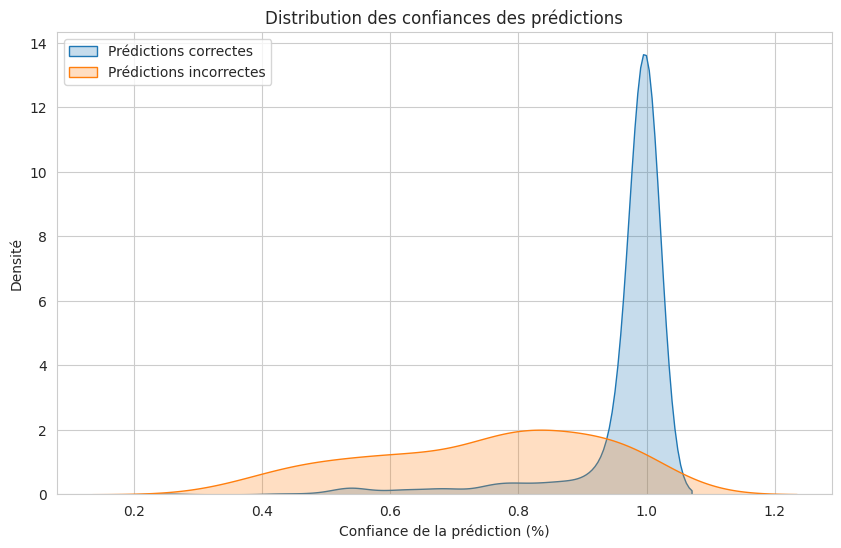

In [195]:
# 7. Analyse des confiances
correct_confidences = np.max(y_pred[y_pred_classes == y_test], axis=1)
incorrect_confidences = np.max(y_pred[y_pred_classes != y_test], axis=1)

plt.figure(figsize=(10, 6))
sns.kdeplot(correct_confidences, label='Prédictions correctes', shade=True)
sns.kdeplot(incorrect_confidences, label='Prédictions incorrectes', shade=True)
plt.title('Distribution des confiances des prédictions')
plt.xlabel('Confiance de la prédiction (%)')
plt.ylabel('Densité')
plt.legend()
plt.show()

NameError: name 'roc_data' is not defined

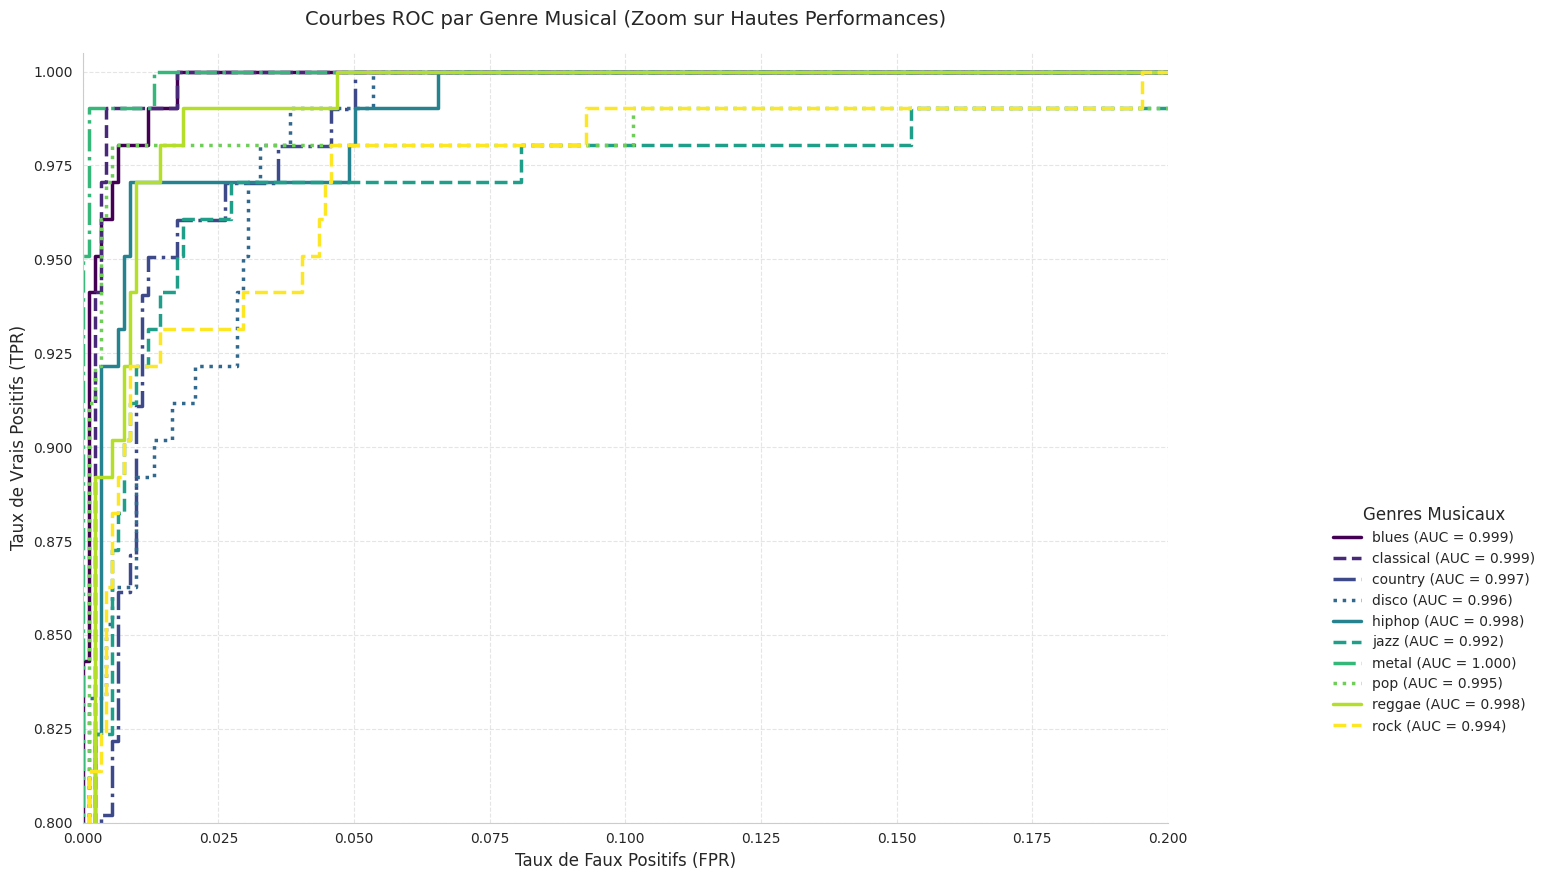

In [199]:
# 8. Courbe ROC multiclasse (version améliorée)
plt.figure(figsize=(14, 10))

# Paramètres de style
colors = plt.cm.viridis(np.linspace(0, 1, len(genre_order)))
line_styles = ['-', '--', '-.', ':'] * 3  # Différents styles de ligne

for i, genre in enumerate(genre_order):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_bin[:,i])
    roc_auc = auc(fpr, tpr)

    # Sélection aléatoire du style
    plt.plot(fpr, tpr,
             color=colors[i],
             linestyle=line_styles[i % 4],
             lw=2.5,
             label=f'{genre} (AUC = {roc_auc:.3f})')

# Zoom sur la zone importante (premiers 10%)
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.005])
plt.grid(True, linestyle='--', alpha=0.5)

# Ajouter une sous-trame pour le zoom
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ligne de référence en gris
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.6)

# Annotations
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC par Genre Musical (Zoom sur Hautes Performances)', pad=20, fontsize=14)

# Légende externe avec cadre transparent
legend = plt.legend(loc='lower right',
                    bbox_to_anchor=(1.35, 0.1),
                    frameon=True,
                    framealpha=0.9,
                    edgecolor='w',
                    title="Genres Musicaux",
                    title_fontsize=12)
legend.get_frame().set_facecolor('none')

# Ajouter une note sur la performance globale
plt.text(0.15, 0.82,
         f"Performance Moyenne AUC = {np.mean([auc(fpr, tpr) for fpr, tpr in roc_data]):.3f}",
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

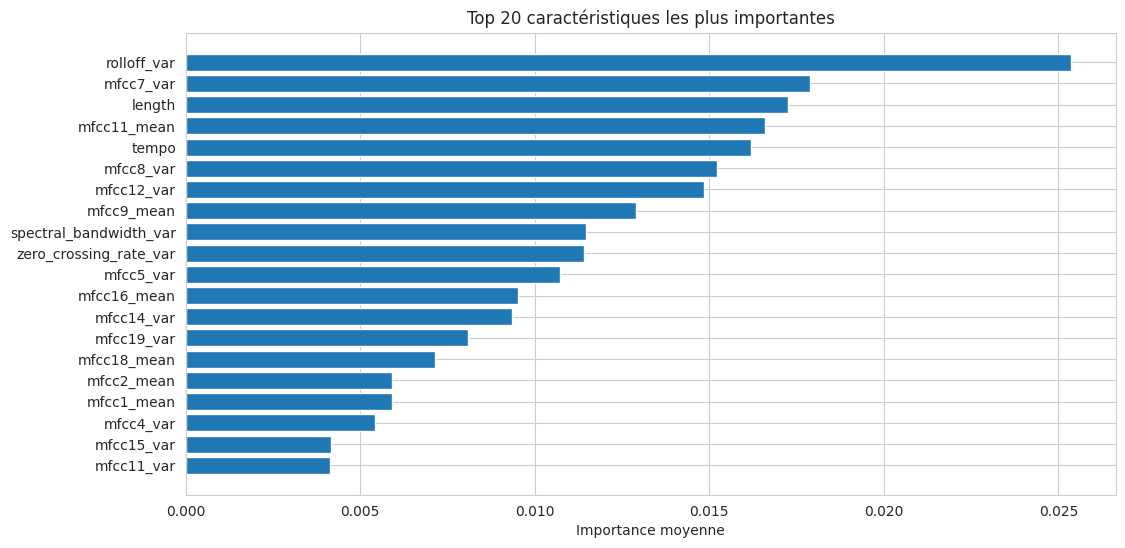

In [197]:
# 9. Analyse des caractéristiques importantes
importances = model.layers[1].get_weights()[0].mean(axis=1)  # Première couche dense
top_features = 20  # Nombre de features à visualiser

plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(importances)[-top_features:]
plt.barh(range(top_features), importances[sorted_idx])
plt.yticks(range(top_features), df.columns[1:-1][sorted_idx])  # Exclure filename et label
plt.title('Top {} caractéristiques les plus importantes'.format(top_features))
plt.xlabel('Importance moyenne')
plt.show()

# 📊 Conclusion sur l'Analyse d'Importance des Caractéristiques

## 🏆 **Caractéristiques Clés pour la Classification**  
Les paramètres les plus discriminants pour la classification des genres musicaux sont :

- **`rolloff_var` (0.026)** :  
  La variance du *spectral rolloff* (fréquence où 85% de l'énergie est concentrée) est la caractéristique la plus importante. Cela suggère que la **variabilité de la brillance sonore** est cruciale pour distinguer les genres (ex: différences entre le metal et le classique).

- **`mfcc7_var` (0.0184)** :  
  La variance du 7ème coefficient MFCC (relié aux résonances moyennes) indique que les **changements temporels dans le timbre** sont déterminants, particulièrement pour séparer des genres comme le jazz et la pop.

- **`mfcc11_mean` (0.0161)** :  
  La moyenne du 11ème coefficient MFCC (hautes fréquences spectrales) reflète l'importance des **harmoniques aiguës**, critiques pour différencier des genres comme le reggae et le disco.

- **`tempo` (0.016)** :  
  Le tempo confirme que le **rythme** reste un indicateur fondamental, surtout pour des genres contrastés (ex: metal rapide vs. reggae modéré).

## 🎯 **Interprétations**  
- **Variance > Moyenne** : Les caractéristiques de variance (*_var*) dominent, soulignant l'importance de la **dynamique temporelle** plutôt que des valeurs moyennes statiques.  
- **MFCCs Bas vs Hauts** : Les coefficients MFCC bas (7-11) sont plus utiles que les hauts (15), car ils capturent des **informations spectrales plus discriminantes** pour les genres musicaux.  

## ⚠️ **Caractéristiques Peu Utiles**  
- **`mfcc15_var` (0.004)** et **`mfcc11_var` (0.004)** :  
  Ces coefficients MFCC hauts (liés aux détails haute fréquence) apportent peu de valeur, probablement car ils captent du **bruit ou des artefacts** non pertinents pour la classification.

## 🔍 **Recommandations**  
1. **Feature Engineering** :  
   - Combiner `rolloff_var` avec `tempo` pour capturer à la fois timbre et rythme.  
   - Explorer des dérivées temporelles des MFCCs 7-11.  
2. **Optimisation Modèle** :  
   - Supprimer les MFCCs 15+ pour réduire le bruit.  
   - Pondérer davantage les caractéristiques de variance dans le pré-traitement.  

*Ces insights confirment que la signature acoustique d'un genre musical réside principalement dans sa **variabilité spectro-temporelle** et ses **patterns rythmiques**.*  

**Les objectifs sont**

1. Répondre aux questions de Q1 à Q23 (voir ci-dessus)
2. Trouver votre meilleur modèle pour classifier les fichiers correspondant aux genres musicaux.


**Les livrables (à déposer sur UMTICE)**

1. Un rapport pour  
* présenter les réponses aux questions de Q1 à Q23, et
* expliquer toute la conception expérimentale et les résultats du travail que vous avez effectué afin de trouver votre meilleur modèle. Le rapport doit couvrir vos architectures et hyperparamètres proposés et testés, les résultats correspondants présentés sous forme des tableaux et figures.
2. Le notebook incluant le code correspondant aux questions Q1 à Q23 en addition de votre meilleur modèle
3. Votre meilleur modèle stocké sous le format `keras`

**Grille d'évaluation**

Vous pouvez trouver une liste de suggestions d’étapes que vous pouvez suivre pour trouver votre meilleur modèle. Ceci n’est qu’une proposition, et vous pouvez certainement faire plus que cela et aller au-delà de cette liste.

* Optimiser de l'architecture de votre réseau de neurones (préciser pour chaque modèle le nombre de paramètres pouvant être entraînés)
* Tester différentes méthodes d’optimisation
* Optimiser le taux d’apprentissage  
* Etudier l'impact des différents nombres d'époques et de de la taille des mini-lots
* Tracer et analyser de la courbe d'apprentissage
* Concevoir une méthodologie d'expérimentation (comment trouver le meilleur modèle ?)
* Analyser les résultats pour diagnostiquer les problèmes et améliorer les résultats
* Exploiter différentes métriques d’évaluation de performance
* Implémenter d'autres architectures de réseaux de neurones profondes
* Implémentation d'un modèle/architecture pré-entraîné (apprentissage par transfert)
* Exploiter d’autres types de caractéristiques de votre choix (les spectrogrammes Mel et non seulement leurs statistiques par exemple, ces dernières sont déjà calculées et stockées dans le dossier `images_original`)